In [1]:
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import os
import pickle
from PIL import Image,ImageFilter
import warnings
import scipy.optimize as opt


%matplotlib inline
warnings.filterwarnings('ignore')

font = {'family' : 'Ubuntu',
        'weight' : 'bold',
        'size'   : 20}

matplotlib.rc('font', **font)

In [2]:
def ListofFiles(path):
    filelist=[]
    for root, dirs, files in os.walk(path):
        for file in files:
             filelist.append(os.path.join(root,file))
    return filelist

def getImageValues(Files,EventLimit=1):
    if(type(Files) is list):
        values={}
        count=0
        for file in Files:
            img1=Image.open(file)
            imgArray=np.array(img1)
            values[count]=imgArray
            count+=1
            if(EventLimit==count):
                break
        print(f" {count} frames in dictinary ")
    else:
        img1=Image.open(Files)
        values=np.array(img1)
    return values

def PickleITDump(data,fileName):
    with open(fileName,'wb') as f:
        pickle.dump(data,f)
        
def PickleITRead(fileName):
    with open(fileName,'rb') as f:
        data=pickle.load(f)
    return data

def TwoDGaussian(xy,Amp,x0,sigmax,y0,sigmay):
    x,y=xy
    value=Amp*np.exp(-((x-x0)**2/(2*sigmax**2)+(y-y0)**2/(2*sigmay**2)))
    return value
    

def TwoDGaussianElliptical(xy,Amp,x0,sigmax,y0,sigmay,theta,Shift):
    x,y=xy
    a=np.cos(theta)**2/(2*sigmax**2)+np.sin(theta)**2/(2*sigmay)
    b=-np.sin(2*theta)**2/(4*sigmax**2)+np.sin(2*theta)**2/(4*sigmay)
    c=np.cos(theta)**2/(2*sigmay**2)+np.sin(theta)**2/(2*sigmax)

    value=Shift+Amp*np.exp(-(a*(x-x0)**2+2*b*(x-x0)*(y-y0)+c*(y-y0)**2))
    return value

def TwoDGaussianEllipticalFlat(xy,Amp,x0,sigmax,y0,sigmay,theta,Shift):
    x,y=xy
    a=np.cos(theta)**2/(2*sigmax**2)+np.sin(theta)**2/(2*sigmay)
    b=-np.sin(2*theta)**2/(4*sigmax**2)+np.sin(2*theta)**2/(4*sigmay)
    c=np.cos(theta)**2/(2*sigmay**2)+np.sin(theta)**2/(2*sigmax)

    value=Shift+Amp*np.exp(-(a*(x-x0)**2+2*b*(x-x0)*(y-y0)+c*(y-y0)**2))
    return value.ravel()
        
def gaussian1d(mu,sigma,bins):
    return 1/(sigma * np.sqrt(2 * np.pi)) *np.exp( - (bins - mu)**2 / (2 * sigma**2))


def MaskCreate(pixel,radius,center,plot=False):
    XPixel,YPixel=pixel
    centerX,centerY=center
    x=np.arange(0,XPixel,1)
    y=np.arange(0,YPixel,1)
    xx,yy=np.meshgrid(x,y)
    rr=np.sqrt((xx-centerX)**2+(yy-centerY)**2)
    mask=rr<=radius
    values=np.ones(rr.shape)
    values[mask]=0
    if(plot):
        plt.figure(figsize=(12,8),dpi=300)
        plt.title("Mask Position")
        plt.xlabel("PixelX")
        plt.ylabel("PixelY")
        plt.imshow(values,cmap="gray",origin="lower")
        plt.show()
    
    return mask,values,[centerX,centerY]
    

    

def DrawCircle(centerx,centery,r,pixelSize,amount):
    x=np.arange(0,pixelSize,1)
    xx,yy=np.meshgrid(x,x)
    rr=np.sqrt((xx-centerx)**2 + (yy-centery)**2)
    print(rr.shape)
    values=np.ones(rr.shape)*-1
    plt.figure(figsize=(12,8),dpi=300)
    count=0
    plt.title("Radial Average")
    #plt.xlim(0,512)
    #plt.ylim(0,512)
    print(r)
    for i in r:
        RadiusMask=(rr>=i-0.5)  & (rr<i+0.5)
        values[RadiusMask]=i
        if (count>=amount):
            break;
        count+=1
    plt.contourf(x,x,values,cmap='viridis',levels=r)
    plt.xlabel("kx")
    plt.ylabel("ky")
    plt.colorbar(label="k")
    plt.show()
    
def RadialFilter(wiener,size,xcenter,ycenter,radius):
    xx=np.linspace(0,size,size)
    grid=np.meshgrid(xx,xx)
    r=np.round(np.sqrt((grid[0]-xcenter)**2+(grid[1]-ycenter)**2))
    MaskIn=r<radius
    ones=np.zeros(r.shape)
    positions=np.where(MaskIn)
    print("XXX\n")
    print(grid[0])
    print("YYY\n")
    print(grid[1])
    print("RRR\n")

    print(r)
    positionR=np.floor(np.sqrt((positions[0]-xcenter)**2+(positions[1]-ycenter)**2))
    print(positionR.max())
    print(positionR.min())

    Wiener1d=np.array([])

    for i in positionR:
        Wiener1d=np.append(Wiener1d,wiener[int(i)])
        
    ones[MaskIn]=Wiener1d
    
    return ones
    

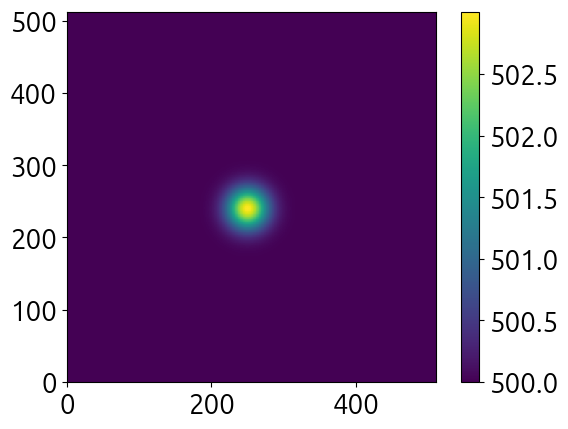

In [3]:
x = np.linspace(0, 512, 512)
xx, yy = np.meshgrid(x, x)

#create data
data = TwoDGaussianEllipticalFlat( (xx, yy),3, 250, 20, 240, 20, 0, 500)

# plot twoD_Gaussian data generated above
plt.figure()
plt.imshow(data.reshape(512,512),interpolation='nearest',origin='lower')
plt.colorbar()

In [4]:
#Particles=PickleITRead("/home/ilker/Downloads/imgs.p")

In [5]:
##### 3 Source in a picture
Images=getImageValues(ListofFiles("/home/argon/Downloads/15_8_7/1s/"),-1)
#Images=getImageValues(ListofFiles("/media/ilker/DATA/CRAB/15_7_8/1s/"),-1)
#Images=getImageValues(ListofFiles("/media/argon/Data/CRAB_Diffusion_Data/CRAB_6_15_2023_10bar/17/1s/"),-1)

 201 frames in dictinary 


(512, 512)


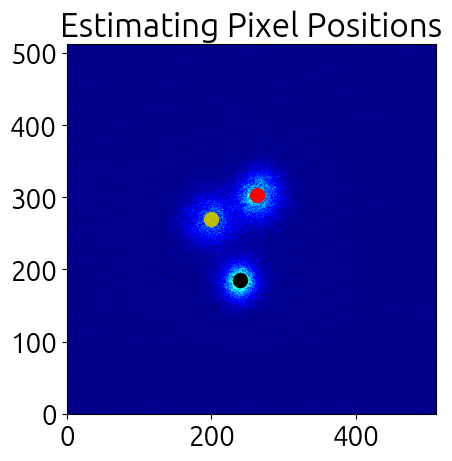

In [6]:
theImage=Images[150]

PixelShape=theImage.shape
print(PixelShape)


plt.title("Estimating Pixel Positions")

plt.imshow(theImage,cmap=plt.cm.jet,origin='lower')

CenterPoint=(200,270)
Needle15cm_Mask=MaskCreate(PixelShape,20,CenterPoint)
plt.scatter(*CenterPoint,s=100,color="y",marker="o") ##  15cm

CenterPoint=(263,303)
Needle10cm_Mask=MaskCreate(PixelShape,20,CenterPoint)
plt.scatter(*CenterPoint,s=100,color="r",marker="o") ##  10cm

CenterPoint=(240,185)

Needle5cm_Mask=MaskCreate(PixelShape,20,CenterPoint)
plt.scatter(*CenterPoint,s=100,color="k",marker="o") ##  5cm

In [1]:


FinalImage=Needle10cm_Mask[1]*theImage*Needle5cm_Mask[1]*Needle15cm_Mask[1]
plt.imshow(FinalImage,cmap=plt.cm.jet,origin='lower')
plt.imshow(Particles["Alphas"][2],vmin=np.mean(Particles["Alphas"][2]),vmax=np.max(Particles["Alphas"][2])*0.6,alpha=0.5)

NameError: name 'Needle10cm_Mask' is not defined

In [8]:
def fit2DToImage(img,initals,it=10000):
    x = np.linspace(0, img.shape[0], img.shape[0])
    xx, yy = np.meshgrid(x, x)
    flattened=theImage.ravel()
    popt, pcov = opt.curve_fit(TwoDGaussianEllipticalFlat, (xx, yy),flattened , p0=initals,maxfev=it,method="lm")
    data_fitted = TwoDGaussianEllipticalFlat((xx, yy), *popt)
    return flattened.reshape(512,512),data_fitted.reshape(512,512),[xx,yy],popt

In [9]:
### Fitting Individual blobs
## 5cm 
initial_guess = np.mean(theImage[Needle5cm_Mask[0]]), Needle5cm_Mask[2][0], 8, Needle5cm_Mask[2][1], 8, 0, 0
Fit_Needle_5cm=fit2DToImage(theImage,initial_guess)



In [10]:
## 10cm 
initial_guess = np.mean(theImage[Needle10cm_Mask[0]]), Needle10cm_Mask[2][0], 2, Needle10cm_Mask[2][1], 2, 0, 0
Fit_Needle_10cm=fit2DToImage(theImage,initial_guess)

In [11]:


## 15cm 
initial_guess = np.mean(theImage[Needle15cm_Mask[0]]), Needle15cm_Mask[2][0], 2, Needle15cm_Mask[2][1], 2,0, -0.3
Fit_Needle_15cm=fit2DToImage(theImage,initial_guess)

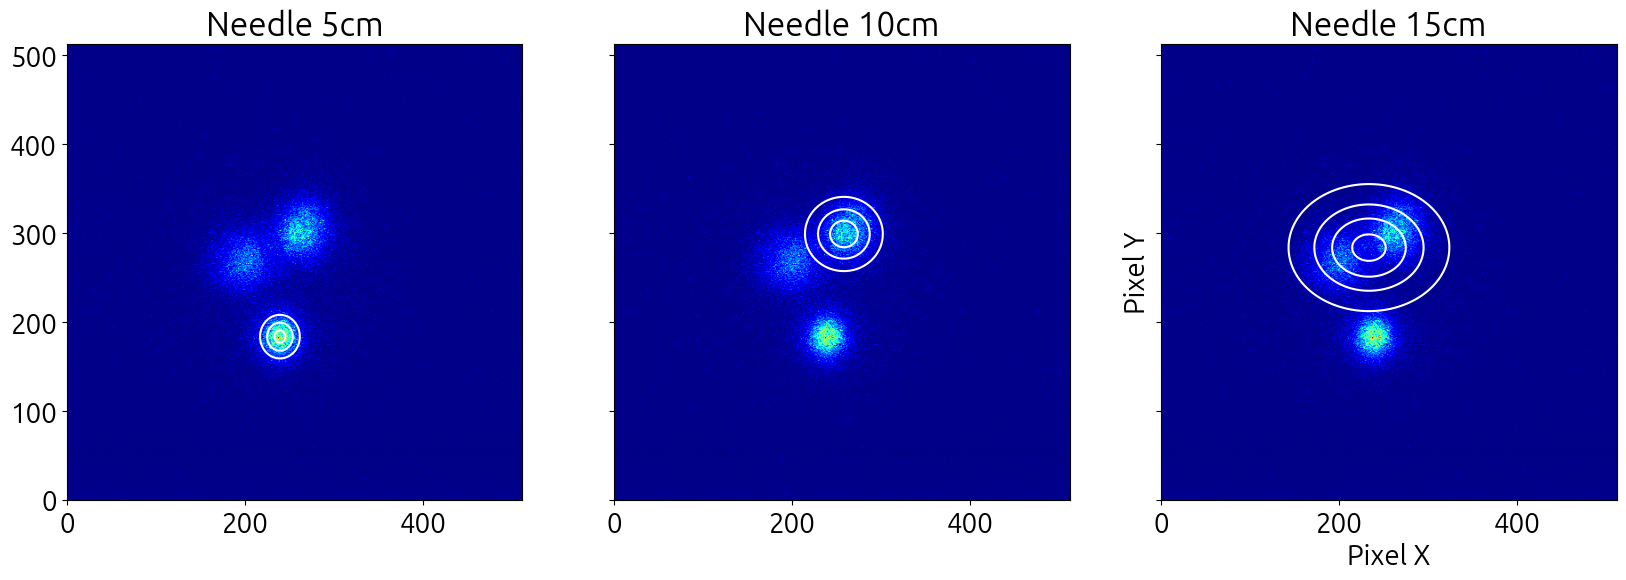

In [12]:
#data_fitted = TwoDGaussianEllipticalFlat((xx, yy), *popt)
#print(data_fitted)
### Single Fitting
fig, ax = plt.subplots(1, 3,sharex=True,sharey=True,figsize=(20,20))
ax[0].set_title("Needle 5cm")
#ax[0].imshow(firstFit[0], cmap=plt.cm.jet, origin='lower',extent=(xx.min(), xx.max(), yy.min(), yy.max()))
ax[0].imshow(Fit_Needle_5cm[0], cmap=plt.cm.jet, origin='lower')
ax[0].contour(Fit_Needle_5cm[2][0], Fit_Needle_5cm[2][1], Fit_Needle_5cm[1], 3, colors='w')

ax[1].set_title("Needle 10cm")
ax[1].imshow(Fit_Needle_10cm[0], cmap=plt.cm.jet, origin='lower')
ax[1].contour(Fit_Needle_10cm[2][0], Fit_Needle_10cm[2][1], Fit_Needle_10cm[1], 3, colors='w')

ax[2].set_title("Needle 15cm")
ax[2].imshow(Fit_Needle_15cm[0], cmap=plt.cm.jet, origin='lower')
ax[2].contour(Fit_Needle_15cm[2][0], Fit_Needle_15cm[2][1], Fit_Needle_15cm[1], 3, colors='w')
plt.xlabel("Pixel X")
plt.ylabel("Pixel Y")

plt.show()


In [13]:
def Sumsof3Gaussian(xy,*fit):
    fit1=fit[0:7]
    fit2=fit[7:14]
    fit3=fit[len(fit)-7:]
    Sum=TwoDGaussianElliptical(xy,*fit1)+TwoDGaussianElliptical(xy,*fit2)+TwoDGaussianElliptical(xy,*fit3)
    return Sum.ravel()

def FitSumsof3Gaussian(img,fit1,fit2,fit3,it=15000):
    x = np.linspace(0, img.shape[0], img.shape[0])
    xx, yy = np.meshgrid(x, x)
    flattened=theImage.ravel()
    print((fit1[3],fit2[3],fit3[3]))
    popt, pcov = opt.curve_fit(Sumsof3Gaussian, (xx, yy),flattened , p0=(fit1[3],fit2[3],fit3[3]),maxfev=it,method="lm")
    data_fitted = Sumsof3Gaussian((xx, yy), *popt)
    return flattened.reshape(512,512),data_fitted.reshape(512,512),[xx,yy],popt
    

In [14]:
Fit_3Gaussian=FitSumsof3Gaussian(theImage,Fit_Needle_5cm,Fit_Needle_10cm,Fit_Needle_15cm)

(array([   6440.06729387,     239.33554651,     240.57480529,
           183.52594902,     199.99594217, -102203.8619555 ,
          2147.13915911]), array([3.41850577e+03, 2.58331490e+02, 6.37488415e+02, 2.98951215e+02,
       7.00867162e+02, 1.54141145e+06, 2.12677030e+03]), array([ 2.29866472e+03,  2.33603119e+02,  4.49717930e+01,  2.83633706e+02,
        3.55322268e+01, -4.61041289e+05,  2.09479318e+03]))


In [15]:
def ConvertToDiffusion(sigmaX,SigmaY,distance,pixelSize,Magnefication,DT=0.92):
    DTX=round((sigmaX/np.sqrt(distance))*pixelSize*Magnefication,2)
    DTY=round((SigmaY/np.sqrt(distance))*pixelSize*Magnefication,2)
    value=round((DTX+DTY)/2,2)
    Error=round(abs(DT-value)/DT,2)
    print(f"Needle Distance is {distance} cm")
    print(f"DT is {value} mm/sqrt(cm) error is {Error*100} %")
    

In [16]:
distance=5
pixelSize=16e-3 #mm
Magnefication=10

246.47740320536667 208.99311040232226
466.2699076686049 364.9857722726474
22.489554265685864 23.000411636268012
Simulation Value for DT is 0.92 mm/sqrt(cm) with 4e7 collisions
 
Needle Distance is 5.46 cm
DT is 15.6 mm/sqrt(cm) error is 1596.0 %
Needle Distance is 10.58 cm
DT is 20.44 mm/sqrt(cm) error is 2122.0 %
Needle Distance is 15.55 cm
DT is 0.92 mm/sqrt(cm) error is 0.0 %


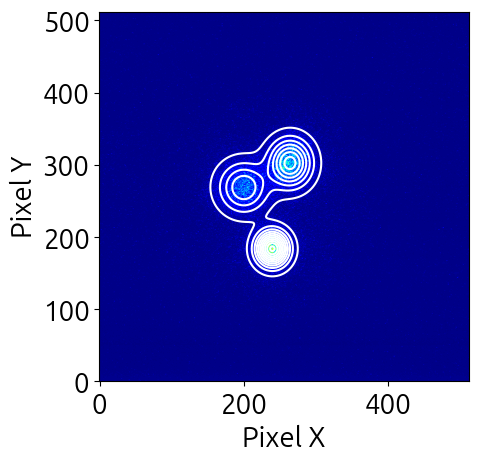

In [17]:

#ax[0].imshow(firstFit[0], cmap=plt.cm.jet, origin='lower',extent=(xx.min(), xx.max(), yy.min(), yy.max()))
plt.imshow(Fit_3Gaussian[0], cmap=plt.cm.jet, origin='lower')
plt.contour(Fit_3Gaussian[2][0], Fit_3Gaussian[2][1], Fit_3Gaussian[1], 10, colors='w')

plt.xlabel("Pixel X")
plt.ylabel("Pixel Y")

#print(Fit_3Gaussian[3])
print(Fit_3Gaussian[3][2],Fit_3Gaussian[3][4])
print(Fit_3Gaussian[3][2+7],Fit_3Gaussian[3][4+7])
print(Fit_3Gaussian[3][2+14],Fit_3Gaussian[3][4+14])

#print("Converting...")
print(f"Simulation Value for DT is 0.92 mm/sqrt(cm) with 4e7 collisions")
print(" ")
ConvertToDiffusion(Fit_3Gaussian[3][2],Fit_3Gaussian[3][4],5.46,pixelSize,10)
ConvertToDiffusion(Fit_3Gaussian[3][2+7],Fit_3Gaussian[3][4+7],10.58,pixelSize,10)
ConvertToDiffusion(Fit_3Gaussian[3][2+14],Fit_3Gaussian[3][4+14],15.55,pixelSize,10)